In [1]:
from numpy import linalg as LA
import numpy as np
import pandas as pd
import math
import networkx as nx
import community
import matplotlib.pyplot as plt
from statsmodels.stats import multitest
from scipy import stats

In [ ]:
def compute_C_minus_C0(lambdas,v,lambda_plus,removeMarketMode=True):
    N=len(lambdas)
    C_clean=np.zeros((N, N))
    
    order = np.argsort(lambdas)
    lambdas,v = lambdas[order],v[:,order]
    
    v_m=np.matrix(v)

    # note that the eivenvalues are sorted
    for i in range(1*removeMarketMode,N):                            
        if lambdas[i]>lambda_plus: 
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)  
    return C_clean    
    
    
def LouvainCorrelationClustering(R):   # R is a matrix of return
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2

    C=R.corr()
    lambdas, v = LA.eigh(C)

    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    
    mygraph= nx.from_numpy_array(np.abs(C_s))
    partition = community.community_louvain.best_partition(mygraph)

    DF=pd.DataFrame.from_dict(partition,orient="index")
    return (DF) 

def FDR(data, alpha=0.05, null_mean=0):
    pvals=[]
    for ticker in data.columns:
        _, p_value = stats.ttest_1samp(data[ticker], null_mean)
        pvals.append(p_value)
    rej, _,_,_ = multitest.multipletests(pvals, alpha=alpha, method='fdr_bh')

    return rej

def market_state_strategy(r, seed=10, addFDR=False): #matrix of log returns
    np.random.seed(seed)

    T=int(np.floor(r.shape[1]/3))
    ret=[0]
    for t in range(T+1,r.shape[0]):
        R = r.iloc[t-T:t]
        DF = LouvainCorrelationClustering(R.T)
        cur_state=DF.iloc[-1][0]
        I = DF[DF[0]==cur_state].index.tolist()
        my_list = [x+1 for x in I[:-1]]

        if not addFDR:
            ar=R.iloc[my_list].mean(axis=0) #normal
            pos = np.sign(ar.values) #normal
        else:
            rej=FDR(R.iloc[my_list], alpha=0.1) # fdr 
            ar=R.iloc[my_list].mean(axis=0)
            pos = np.sign(ar.values)
            pos[~rej] = 0 # fdr

        ret.append(np.dot(pos, np.exp(r.iloc[t].values)-1)/len(pos))

    all_ret=pd.DataFrame({'Strat_A':ret}, index=r.index[T:])
    all_ret['buy_and_hold']=np.concatenate(([0], np.dot(np.exp(r.iloc[T+1:])-1, np.ones(len(pos)))/len(pos)))
    all_ret['Strat_A_perf']=all_ret['Strat_A']+1
    all_ret['Strat_A_perf'].cumprod().plot(label='market_state_strategy')

    all_ret['BH_perf']=all_ret['buy_and_hold']+1
    all_ret['BH_perf'].cumprod().plot(label='buy_and_hold')
    plt.xlabel('time')
    plt.ylabel('USD')
    plt.title('Cumulative_performance')
    plt.legend()
    plt.show()

In [5]:
import matplotlib.cm as cm
import yfinance as yf

alldata=pd.read_csv(r"D:\Document\EPFL_Coursework\FinancialBigData\clean\us_equities_logreturns.csv.gz")
alldata.drop(columns=["Unnamed: 0","^GSPC"], inplace=True)
tickers=alldata.columns.tolist()

all_data = pd.DataFrame()
for ticker in tickers:
    try:
        data = yf.download(ticker, start="2020-08-01", end="2021-01-01",progress=False)
        all_data[ticker] = data['Close']
    except Exception as e:
        print(f"Failed to retrieve data for {ticker}. Error: {e}")

# print(all_data.head())
data_subset=all_data.dropna(axis=1)
log_return=np.log(data_subset).diff()
log_return.head()


1 Failed download:
['UTX']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['NAV']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['AET']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-08-01 -> 2021-01-01)')

1 Failed download:
['CNW']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-08-01 -> 2021-01-01)')

1 Failed download:
['MOT']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-08-01 -> 2021-01-01)')

1 Failed download:
['DBD']: Exception("%ticker%: Data doesn't exist for startDate = 1596254400, endDate = 1609477200")

1 Failed download:
['RSH']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-08-01 -> 2021-01-01)')

1 Failed download:
['RTN']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['AVP']: Exception('%ticker%: No timezone found, symbol may be delisted')


,GE,IBM,DIS,BA,CAT,AA,HPQ,DD,KO,XOM,...,FAF,CEM,VSH,BIO,GM,FF,FIF,BFS,CTR,KIM
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-04,0.004898,0.012233,0.008047,0.017108,-0.001975,-0.000731,0.006730,0.013255,0.008388,0.028467,...,0.020084,0.028287,0.041495,-0.007902,0.006221,-0.006826,-0.001986,0.029390,0.026058,0.039775
2020-08-05,0.041473,-0.003104,0.084329,0.054294,0.025894,0.071282,0.004462,0.029106,0.011288,0.008704,...,0.002061,0.045220,0.017186,0.000835,0.020335,0.015855,0.008906,0.003249,0.027673,-0.019248
2020-08-06,-0.010998,0.005327,0.024844,-0.012007,-0.004307,0.014875,0.016557,-0.000366,0.005491,-0.004801,...,-0.003751,0.013562,-0.004711,-0.003952,0.010954,0.026609,0.001969,0.001297,0.031346,0.010545
2020-08-07,0.010998,-0.009240,-0.006827,-0.012740,0.003936,-0.015557,0.010887,0.020981,0.006717,-0.004594,...,0.013253,0.015909,-0.012474,-0.002077,0.003749,0.042134,0.000983,0.020203,-0.002207,0.041940


In [11]:
def FDR(data, alpha=0.05, null_mean=0):
    pvals=[]
    for ticker in data.columns:
        t_statistic, p_value = stats.ttest_1samp(data[ticker], null_mean)
        pvals.append(p_value)
    rej, _, _, _ = multitest.multipletests(pvals, alpha=alpha, method='fdr_bh')
    return rej

r=log_return
T=int(np.floor(r.shape[1]/3))
ret=[1]
for t in range(T+1,T+2):
    R = r.iloc[t-T:t]
    df = LouvainCorrelationClustering(R.T)
    pre_state=df.iloc[-1][0]
    I = df[df[0]==pre_state].index.tolist()
    my_list = [x+1 for x in I[:-1]]
    rej=FDR(R.iloc[my_list])
    ar=R.iloc[my_list].mean(axis=0)
    pos = np.sign(ar.values)
    pos[~rej] = 0
    ret.append(np.dot(pos, np.exp(r.iloc[t].values)-1)/len(pos)+1)



IndexError: single positional indexer is out-of-bounds

C:\Users\E.M.Lau\AppData\Local\Temp\ipykernel_15572\650695569.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_chopped['rolling_ret']=ret
C:\Users\E.M.Lau\AppData\Local\Temp\ipykernel_15572\650695569.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chopped['rolling_ret']=ret
C:\Users\E.M.Lau\AppData\Local\Temp\ipykernel_15572\650695569.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

Text(0.5, 1.0, 'Cumulative_return')

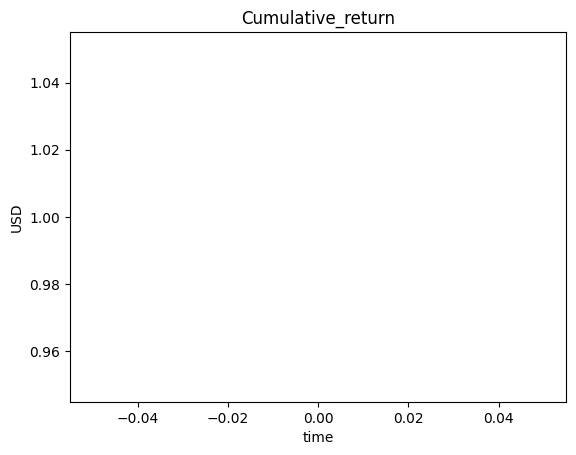

In [9]:
# data_subset=all_data.dropna(axis=1)
# r=np.log(data_subset).diff()
r=log_return
T=int(np.floor(r.shape[1]/3))
ret=[1]
for t in range(T+1,r.shape[0]):
    R = r.iloc[t-T:t]
    df = LouvainCorrelationClustering(R.T)
    pre_state=df.iloc[T-1][0]
    I = df[df[0]==pre_state].index.tolist()
    my_list = [x+1 for x in I[:-1]]
    ar=R.iloc[my_list].mean(axis=0)
    pos = np.sign(ar.values)
    ret.append(np.dot(pos, np.exp(r.iloc[t].values)-1)/len(pos)+1)

df_chopped = r.iloc[T:]
df_chopped['rolling_ret']=ret
df_chopped['cumulative_perf']=df_chopped['rolling_ret'].cumprod()
df_chopped['cumulative_perf'].plot()
plt.xlabel('time')
plt.ylabel('USD')
plt.title('Cumulative_return')

# Intraday test

In [14]:
# from market_state_strategy import market_state_strategy
from upload_data import load_all
import pandas as pd

df = load_all(start_date = pd.to_datetime('2007-04-15'), end_date=pd.to_datetime('2007-4-30'), dirBase="data/raw/equities/")

df.info()


No data in the given period for ticker ORCL.N
No data in the given period for ticker MSFT.O
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-16-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-17-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-18-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-19-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-20-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-23-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-24-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-25-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-26-APA.N-bbo.parquet
load_TRTH_bbo could not load data/raw/equities//US/bbo/APA.N/2007-04-27-APA.N-bbo.parquet
load_TRT

In [11]:
# grouped = df.set_index(['ticker'])
df2=df.set_index(['ticker'], append=True, inplace=False)
result=df2[['trade_price']]
all=result.unstack(level='ticker')
all_fill = all.ffill().bfill()


C:\Users\E.M.Lau\AppData\Local\Temp\ipykernel_15572\1014571559.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chopped['rolling_ret']=ret
C:\Users\E.M.Lau\AppData\Local\Temp\ipykernel_15572\1014571559.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chopped['cumulative_perf']=df_chopped['rolling_ret'].cumprod()


Text(0.5, 1.0, 'Cumulative_return')

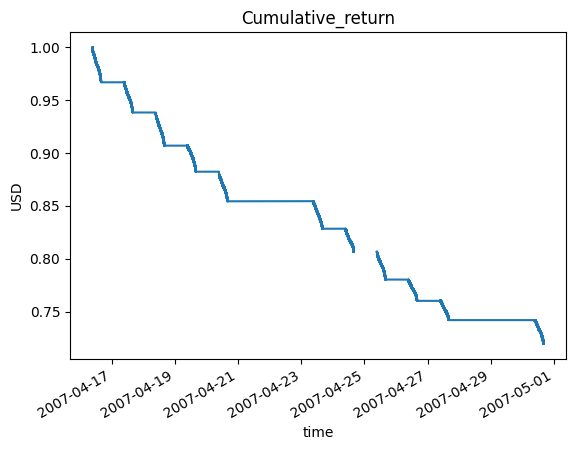

In [12]:
# from numpy import linalg as LA
import numpy as np
# import pandas as pd
# import math
# import networkx as nx
# import community
# import matplotlib.pyplot as plt

# all_reset = all_fill.reset_index(drop=True)
r=np.log(all_fill).diff()
# r.tail()
T=int(np.floor(r.shape[1]/3))
ret=[1]
for t in range(T+1,r.shape[0]):
    R = r.iloc[t-T:t]
    df = LouvainCorrelationClustering(R.T)
    pre_state=df.iloc[T-1][0]
    I = df[df[0]==pre_state].index.tolist()
    my_list = [x+1 for x in I[:-1]]
    ar=R.iloc[my_list].mean(axis=0)
    pos = np.sign(ar.values)
    ret.append(np.dot(pos, np.exp(r.iloc[t].values)-1)/len(pos)+1)

df_chopped = r.iloc[T:]
df_chopped['rolling_ret']=ret
df_chopped['cumulative_perf']=df_chopped['rolling_ret'].cumprod()
df_chopped['cumulative_perf'].plot()
plt.xlabel('time')
plt.ylabel('USD')
plt.title('Cumulative_return')
# market_state_strategy(r)

# clusters by minutes

In [7]:
filepath1=r"D:\Document\EPFL_Coursework\FinancialBigData\clean\2007-01-01-to-2007-01-31-vwap.parquet"
filepath2=r"D:\Document\EPFL_Coursework\FinancialBigData\clean\2007-02-01-to-2007-02-28-vwap.parquet"
filepath3=r"D:\Document\EPFL_Coursework\FinancialBigData\clean\2007-03-01-to-2007-04-30-vwap.parquet"
df1=pd.read_parquet(filepath1)
df2=pd.read_parquet(filepath2)
df3=pd.read_parquet(filepath3)
df = pd.concat([df1, df2, df3])
# df2=df.set_index(['minute','ticker'])
# result=df2['vwap']
all=df.set_index(['minute','ticker']).unstack(level='ticker')

df1.set_index(['minute','ticker']).unstack(level='ticker')
#all.info()


vwap             ...                      
ticker                 AA.N      ABT.N  ...      XOM.N      XRX.N
minute                                  ...                      
2007-01-03 14:30        NaN  48.833295  ...        NaN  16.969097
2007-01-03 14:31  29.886544  48.924805  ...        NaN  16.979139
2007-01-03 14:32  29.902933  48.979192  ...  75.669337  17.017634
2007-01-03 14:33  29.950623  48.998300  ...  75.703973  17.060000
2007-01-03 14:34  29.979737  48.979465  ...  75.514586  17.066284
...                     ...        ...  ...        ...        ...
2007-01-31 20:55  32.342440  53.019104  ...  74.496065  17.199146
2007-01-31 20:56  32.336449  53.001100  ...  74.442696  17.200000
2007-01-31 20:57  32.335146  52.997829  ...  74.456002  17.198929
2007-01-31 20:58  32.312291  52.981176  ...  74.270007  17.188710
2007-01-31 20:59  32.297463  52.988022  ...  74.266910  17.190583

[7800 rows x 82 columns]

In [3]:
all_fill = all.ffill().bfill()
r=np.log(all_fill).diff()

# r.head()

vwap                                                \
ticker                AA.N     ABT.N     AEP.N     ALL.N     AVP.N AXP.N   
minute                                                                     
2007-01-03 14:30       NaN       NaN       NaN       NaN       NaN   NaN   
2007-01-03 14:31  0.000000  0.001872  0.000000  0.002321  0.002926   0.0   
2007-01-03 14:32  0.000548  0.001111  0.000452  0.002795  0.001714   0.0   
2007-01-03 14:33  0.001594  0.000390  0.002178  0.002450  0.001814   0.0   
2007-01-03 14:34  0.000972 -0.000384  0.001569  0.000240  0.000240   0.0   

                                                         ...            \
ticker                BA.N     BAC.N     BAX.N    BHI.N  ...     USB.N   
minute                                                   ...             
2007-01-03 14:30       NaN       NaN       NaN      NaN  ...       NaN   
2007-01-03 14:31 -0.000243  0.000421  0.001649  0.00000  ...  0.009991   
2007-01-03 14:32  0.002606  0.000409  0.000428  0.00000  ...  0.002070   
2007-01-03 14:33  0.002929  0.001155  0.003258  0.00000  ...  0.001169   
2007-01-03 14:34 -0.001462  0.002929  0.001006 -0.00746  ...  0.000523   

                                                                               \
ticker               UTX.N VZ.N     WAG.N WFC.N     WMB.N     WMT.N      WY.N   
minute                                                                          
2007-01-03 14:30       NaN  NaN       NaN   NaN       NaN       NaN       NaN   
2007-01-03 14:31  0.005463  0.0  0.005988   0.0  0.000000  0.000683  0.000000   
2007-01-03 14:32 -0.000085  0.0  0.002671   0.0  0.000000  0.000550  0.000000   
2007-01-03 14:33  0.000537  0.0  0.001160   0.0 -0.004210  0.002283  0.003155   
2007-01-03 14:34 -0.000082  0.0 -0.001137   0.0 -0.004731  0.002832  0.002551   

                                      
ticker               XOM.N     XRX.N  
minute                                
2007-01-03 14:30       NaN       NaN  
2007-01-03 14:31  0.000000  0.000592  
2007-01-03 14:32  0.000000  0.002265  
2007-01-03 14:33  0.000458  0.002486  
2007-01-03 14:34 -0.002505  0.000368  

[5 rows x 82 columns]

In [9]:
def FDR(data, alpha=0.05, null_mean=0):
    pvals=[]
    for ticker in data.columns:
        _, p_value = stats.ttest_1samp(data[ticker], null_mean)
        pvals.append(p_value)
    rej, _,_,_ = multitest.multipletests(pvals, alpha=alpha, method='fdr_bh')

    # pvals_sortind = np.argsort(pvals)
    # pvals_sorted = np.take(pvals, pvals_sortind)
    # nobs = len(pvals_sorted)
    # ecdffactor =  np.arange(1,nobs+1)/float(nobs)
    # reject = pvals_sorted <= ecdffactor*alpha
    # if reject.any():
    #     rejectmax = max(np.nonzero(reject)[0])
    #     reject[:rejectmax] = True
    return rej

T=int(np.floor(r.shape[1]/3))
ret=[1]
for t in range(T+11,T+12):
    R = r.iloc[t-T:t]
    # print(R)
    df = LouvainCorrelationClustering(R.T)
    pre_state=df.iloc[-1][0]
    I = df[df[0]==pre_state].index.tolist()
    my_list = [x+1 for x in I[:-1]]
    # sample=R.iloc[my_list]
    # print(sample)

    # null_mean=0
    # alpha=0.6
    # pvals=[]
    # for ticker in sample.columns:
    #     _, p_value = stats.ttest_1samp(sample[ticker], null_mean)
    #     pvals.append(p_value)
    # pvals_sortind = np.argsort(pvals)
    # pvals_sorted = np.take(pvals, pvals_sortind)
    # nobs = len(pvals_sorted)
    # ecdffactor =  np.arange(1,nobs+1)/float(nobs)
    # rs=ecdffactor*alpha
    # reject = pvals_sorted <= ecdffactor*alpha
    # if reject.any():
    #     rejectmax = max(np.nonzero(reject)[0])
    #     reject[:rejectmax] = True

    rej=FDR(R.iloc[my_list], alpha=0.7)
    ar=R.iloc[my_list].mean(axis=0)
    pos = np.sign(ar.values)
    pos[~rej] = 0
    ret.append(np.dot(pos, np.exp(r.iloc[t].values)-1)/len(pos)+1)

C:\Users\E.M.Lau\AppData\Local\Temp\ipykernel_8880\833146811.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chopped['rolling_ret']=ret
C:\Users\E.M.Lau\AppData\Local\Temp\ipykernel_8880\833146811.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chopped['cumulative_perf']=df_chopped['rolling_ret'].cumprod()


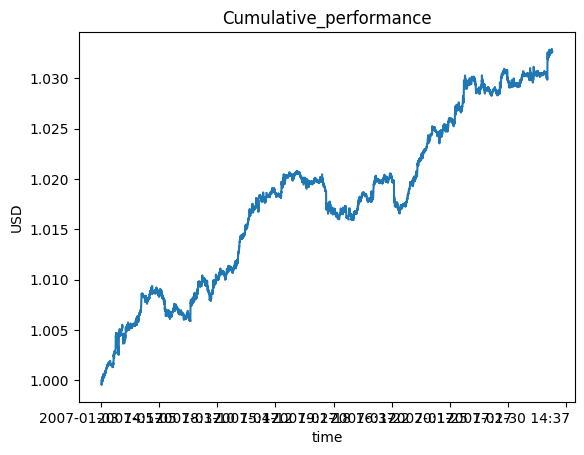

In [22]:
market_state_strategy(r)

In [4]:
T=int(np.floor(r.shape[1]/3))
kkk=np.concatenate(([0], np.dot(np.exp(r.iloc[T+1:])-1, np.ones(r.shape[1]))))


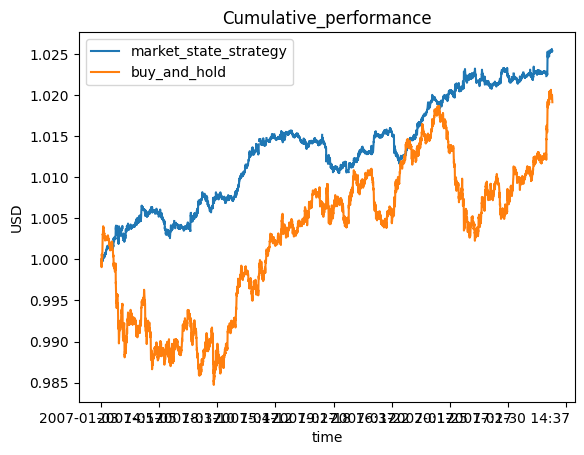

In [5]:
market_state_strategy(r)

# four months

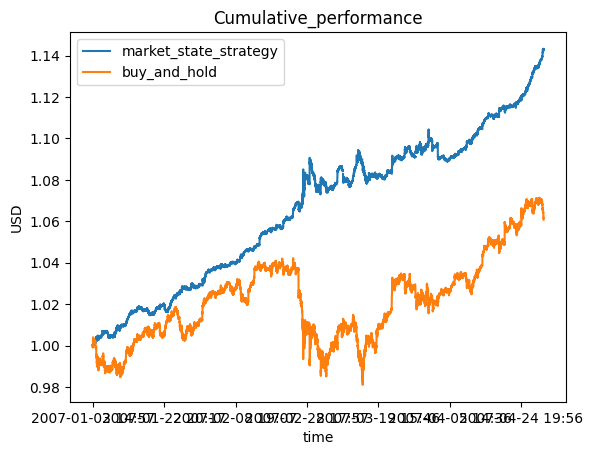

In [9]:
market_state_strategy(r)

## With FDR with $\alpha$=0.7

d:\Document\EPFL_Coursework\FinancialBigData\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Document\EPFL_Coursework\FinancialBigData\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Document\EPFL_Coursework\FinancialBigData\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Document\EPFL_Coursework\FinancialBigData\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Document\EPFL_Coursework\FinancialBigData\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Document\EPFL_Coursework\FinancialBigData\.v

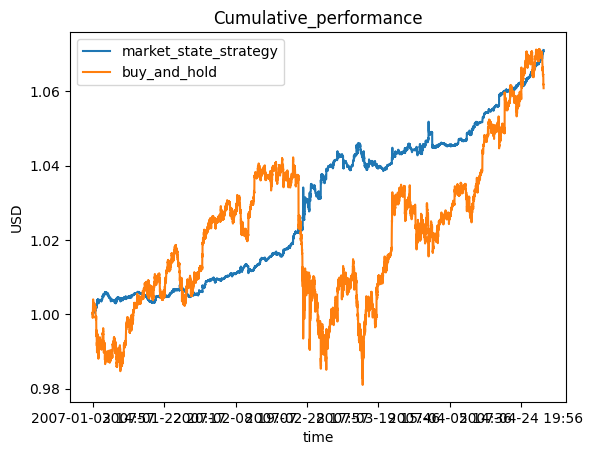

In [4]:
market_state_strategy(r)

# 2007

In [2]:
from upload_data import upload_clean_data
from market_state_strategy import market_state_strat_upgraded, strat_eval

filepath=r"D:\Document\EPFL_Coursework\FinancialBigData\clean\SP500_2007"
all_data=upload_clean_data(filepath)

In [3]:
all=all_data.set_index(['minute','ticker']).unstack(level='ticker')

non_null_counts = all.count()
selected_columns = non_null_counts[non_null_counts > 90000].index
all_filtered = all[selected_columns]
all_filtered.index = pd.to_datetime(all_filtered.index)
all_filtered.index = all_filtered.index + pd.Timedelta(minutes=1)

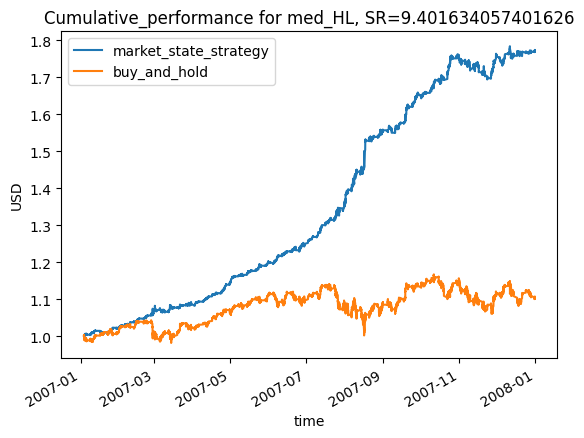

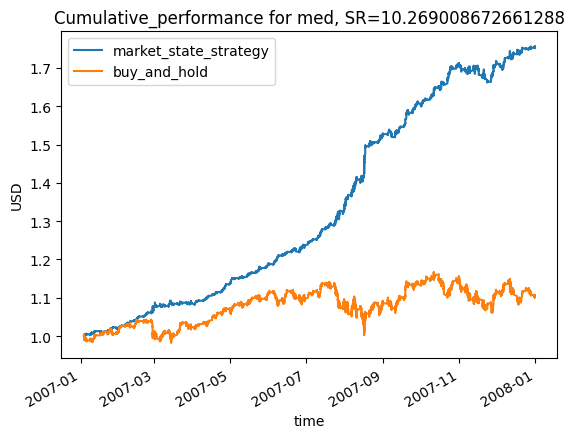

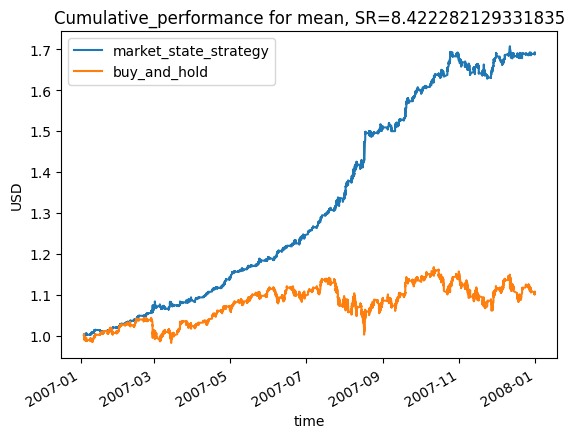

In [5]:
all_fill = all_filtered.ffill().bfill()
r=np.log(all_fill).diff()
Ms=['med_HL', 'med', 'mean']
for m in Ms:
    ret=market_state_strat_upgraded(r, trend_measure=m)
    strat_eval(ret, m)
    
